In [11]:
import numpy as np
import pandas as pd

def load_features(model_name):
    return np.load(f'{model_name}_features.npz')['data']
dt = pd.read_csv('subset-LA-even.csv')
# Define the list of model names

In [12]:
model_names = ['distilroberta','bert-cased']#,'bert', 'bert-large', 'gpt2', 'roberta', 'roberta-large', 'xlnet', 'xlnet-large','albert','albert-large']#[]


In [14]:
for M in model_names:
    NLP = load_features(M)
    
    print(M, NLP.shape)

distilroberta (48714, 768)
bert-cased (48714, 768)


In [2]:
# dt.fulltext[9]

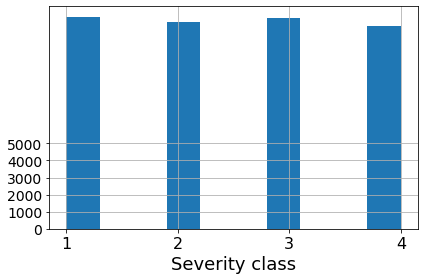

In [15]:
import matplotlib.pyplot as plt
plt.hist(dt.Severity)
plt.xticks(np.arange(1,5),fontsize=16)
plt.xlabel('Severity class',fontsize=18)
plt.grid()
plt.yticks(np.arange(0,6000,1000),fontsize=14)
plt.tight_layout()
plt.savefig('S-hist.pdf')

In [18]:
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score


def cross_validate_classification(model, X, y, kf=None):
    kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=123) if kf is None else kf
    
    kf.get_n_splits(X, y)
    
    accuracy_scores = []
    f1_scores = []
    precision_scores = []
    recall_scores = []
    for i, (train_index, test_index) in enumerate(kf.split(X, y)):
        # Create a clone of the model to ensure that the model's initial state is preserved
        model_clone = clone(model)
        # Split the data
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        # Fit the model
        model_clone.fit(X_train, y_train)
        # Make predictions
        y_pred = model_clone.predict(X_test)
        # Calculate accuracy
        accuracy_scores.append(accuracy_score(y_test, y_pred))
        # Calculate F1 score
        f1_scores.append(f1_score(y_test, y_pred, average='macro'))
        # Calculate precision
        precision_scores.append(precision_score(y_test, y_pred, average='macro'))
        # Calculate recall
        recall_scores.append(recall_score(y_test, y_pred, average='macro'))
    # Calculate average scores
    average_accuracy = np.mean(accuracy_scores)
    average_f1 = np.mean(f1_scores)
    average_precision = np.mean(precision_scores)
    average_recall = np.mean(recall_scores)
    return average_accuracy, average_f1, average_precision, average_recall


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

import lightgbm as lgb
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
models = {
    "Light GBM": lgb.LGBMClassifier(n_estimators=100, n_jobs=45),
    "K-Nearest Neighbors": KNeighborsClassifier(n_jobs=45),
#     "Logistic Regression": LogisticRegression(max_iter=2000, solver='lbfgs', multi_class='auto'),
    "Random Forest": RandomForestClassifier(n_estimators=100, n_jobs=45),
#     "Support Vector Classifier": SVC(),
#     "Decision Tree": DecisionTreeClassifier(),
    
#     "Multinomial Naive Bayes": MultinomialNB(),
    "XGBoost": XGBClassifier(n_estimators=100, n_jobs=45)
}

from sklearn.decomposition import PCA

def perform_pca(features, n_components):
    """
    Perform Principal Component Analysis (PCA) on the provided features.

    Args:
    features: numpy array of features
    n_components: number of principal components to retain

    Returns:
    A numpy array where each row is the original feature vector projected onto the top `n_components` principal components.
    """
    print("Starting PCA...")
    print(features.shape)
    # Initialize PCA
    pca = PCA(n_components=n_components)

    # Fit and transform the data
    reduced_features = pca.fit_transform(features)

    print("PCA complete.")
    print(f"Reduced data shape: {reduced_features.shape}")

    return reduced_features

#'mt5', 'mt5-large'


model_names = ['bert', 'bert-large', 'roberta', 'roberta-large', 'xlnet', 'xlnet-large','albert','albert-large']#[]

model_names = ['distilroberta','bert-cased']

feature_sets = ['NLP']


BASE = dt.drop(['Severity'],axis=1).values

SX = dt.Severity.values

results = []


reportonce=False


for language_model in model_names:
    print(f"Loading features for language model: {language_model}...")
    NLP = load_features(language_model)
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    NLP = scaler.fit_transform(NLP)
#     quantile_transformer = QuantileTransformer(output_distribution='uniform')
#     NLP = quantile_transformer.fit_transform(NLP)
    
#     NLP = perform_pca(NLP, 32)
#     from sklearn.preprocessing import MinMaxScaler

    from sklearn.preprocessing import QuantileTransformer


    
    XES=None
    
    
    for feature_set in feature_sets:
        if feature_set == 'NLP':
            XES = NLP
            
        elif feature_set == 'report':
            
            if reportonce:
                continue
                
            XES = BASE
            reportonce=True
        elif feature_set == 'report+NLP':
            XES = np.concatenate([BASE,NLP],axis=1)
            
        print(language_model, feature_set)
        
#         quantile_transformer = QuantileTransformer(output_distribution='uniform')
#         XES = quantile_transformer.fit_transform(XES)
        
        
#         scaler = StandardScaler()
#         XES = scaler.fit_transform(XES)

        
        for model_name, model in models.items():
            print(f"Cross-validating {model_name}...")
            average_accuracy, average_f1, average_precision, average_recall = cross_validate_classification(model, XES, SX-1)
            results.append([model_name, language_model, feature_set, average_accuracy, average_f1, average_precision, average_recall])
            print(f"{model_name} cross-validation complete. \n\tAverage Accuracy: {average_accuracy},\n\tAverage F1 Score: {average_f1},\n\tAverage Precision: {average_precision},\n\tAverage Recall: {average_recall}\n")



Loading features for language model: distilroberta...
distilroberta NLP
Cross-validating Light GBM...
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072025 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 43842, number of used features: 768
[LightGBM] [Info] Start training from score -1.368794
[LightGBM] [Info] Start training from score -1.391738
[LightGBM] [Info] Start training from score -1.372747
[LightGBM] [Info] Start training from score -1.412500
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.054940 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 43842, number of used features: 768
[LightGBM] [Info] Start training from score -1.368794
[LightGBM] [Info] Start training from 

/home/agrigore/ENV/lib64/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:23:41] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/agrigore/ENV/lib64/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:24:44] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/agrigore/ENV/lib64/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:25:46] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/agrigore/ENV/lib64/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:26:49] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/agrigore/ENV/lib64/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:27:51] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/agrigore/ENV/lib64/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:28:54] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/agrigore/ENV/lib64/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:29:57] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/agrigore/ENV/lib64/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:30:59] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/agrigore/ENV/lib64/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:32:02] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/agrigore/ENV/lib64/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:33:05] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBoost cross-validation complete. 
	Average Accuracy: 0.8691342380544486,
	Average F1 Score: 0.8689520979108059,
	Average Precision: 0.8716598475020902,
	Average Recall: 0.8690021134516959

Loading features for language model: bert-cased...
bert-cased NLP
Cross-validating Light GBM...
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.075087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 43842, number of used features: 768
[LightGBM] [Info] Start training from score -1.368794
[LightGBM] [Info] Start training from score -1.391738
[LightGBM] [Info] Start training from score -1.372747
[Li

/home/agrigore/ENV/lib64/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:37:04] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/agrigore/ENV/lib64/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:38:07] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/agrigore/ENV/lib64/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:39:10] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/agrigore/ENV/lib64/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:40:13] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/agrigore/ENV/lib64/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:41:15] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/agrigore/ENV/lib64/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:42:18] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/agrigore/ENV/lib64/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:43:21] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/agrigore/ENV/lib64/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:44:25] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/agrigore/ENV/lib64/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:45:29] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/agrigore/ENV/lib64/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:46:33] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBoost cross-validation complete. 
	Average Accuracy: 0.8892106368949436,
	Average F1 Score: 0.889293889844318,
	Average Precision: 0.890529121793658,
	Average Recall: 0.88916256954726



In [19]:
results_df = pd.DataFrame(results, columns=['Model', 'Language Model','Features','Average Accuracy', 'Average F1 Score', 'Average Precision', 'Average Recall']).round(3)
results_df


,Model,Language Model,Features,Average Accuracy,Average F1 Score,Average Precision,Average Recall
0,Light GBM,distilroberta,NLP,0.868,0.867,0.871,0.867
1,K-Nearest Neighbors,distilroberta,NLP,0.848,0.848,0.853,0.848
2,Random Forest,distilroberta,NLP,0.857,0.857,0.862,0.857
3,XGBoost,distilroberta,NLP,0.869,0.869,0.872,0.869
4,Light GBM,bert-cased,NLP,0.889,0.889,0.890,0.889
5,K-Nearest Neighbors,bert-cased,NLP,0.878,0.878,0.881,0.878
6,Random Forest,bert-cased,NLP,0.880,0.880,0.883,0.880
7,XGBoost,bert-cased,NLP,0.889,0.889,0.891,0.889


In [11]:
# results_df.to_csv('tmp.csv')

In [20]:
results_df.loc[results_df['Features'] == 'report', 'Language Model'] = '-'

In [21]:
# def calculate_average(df):
#     df = df.copy()  # Make a copy of the DataFrame to avoid modifying the original
#     # Group by 'Features' and 'Model', then calculate mean for 'Average RMSE' and 'Average MAPE'
#     df_avg = df.groupby(['Language Model','Features', 'Model'], as_index=False).mean()
    
#     return df_avg
# results_df = calculate_average(results_df)
results_df.to_csv('DESC-results-LLM-flat-even-severity-2.csv')

In [ ]:
results_df = pd.DataFrame(results, columns=['Language Model', 'Features', 'Model', 'Average RMSE', 'Average MAPE']).round(2)
print(results_df)

In [23]:
results_df = pd.DataFrame(results, columns=['Language Model', 'Features', 'Model', 'Average RMSE', 'Average MAPE']).round(2)
print(results_df)

results_df.loc[results_df['Features'] == 'report', 'Language Model'] = '-'

results_df.to_csv('results-LLM-32-even-duration-final-BL.csv')

def calculate_average(df):
    df = df.copy()  # Make a copy of the DataFrame to avoid modifying the original
    # Group by 'Features' and 'Model', then calculate mean for 'Average RMSE' and 'Average MAPE'
    df_avg = df.groupby(['Language Model','Features', 'Model'], as_index=False).mean().round(2)
    
    return df_avg
results_df = calculate_average(results_df)
results_df.to_csv('results-LLM-32-even-duration-final-BL.csv')

ValueError: 5 columns passed, passed data had 7 columns

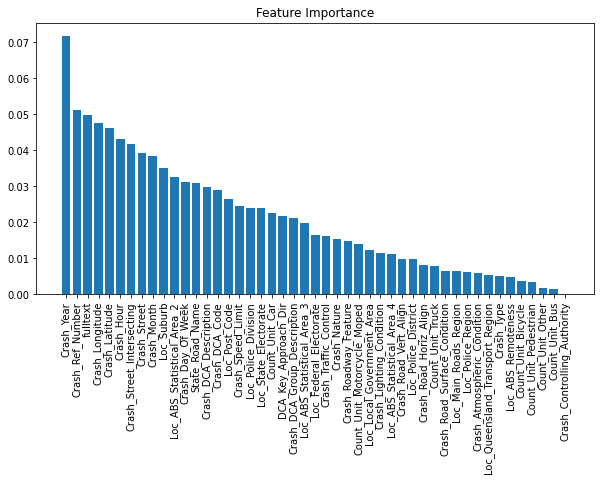

In [18]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# I assume 'dt' is your DataFrame and 'BASE' and 'SX' are numpy arrays
# BASE = dt.drop(['Crash_Severity'], axis=1).values
# SX = dt.Crash_Severity.values

# Initialize the Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=0)

# Fit the model
clf.fit(dt.drop(['Crash_Severity'],axis=1), SX)

# Get feature importances
feature_importances = clf.feature_importances_

# Get feature names
feature_names = dt.drop(['Crash_Severity'], axis=1).columns

# Sort feature importances in descending order and get the indices
indices = np.argsort(feature_importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
names = [feature_names[i] for i in indices]

# Create a plot
plt.figure(figsize=(10, 5))

# Create plot title
plt.title("Feature Importance")

# Add bars
plt.bar(range(BASE.shape[1]), feature_importances[indices])

# Add feature names as x-axis labels
plt.xticks(range(BASE.shape[1]), names, rotation=90)

# Show plot
plt.show()


In [3]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, ElasticNet
from math import sqrt
import pandas as pd
from sklearn.base import clone

# Define the models
models = {
    "Linear Regression": LinearRegression(),
    "ElasticNet": ElasticNet(),
    "DecisionTree": DecisionTreeRegressor(),
    "XGBoost": XGBRegressor(n_estimators=50, n_jobs=1) 
}



def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.expm1(y_true), np.expm1(y_pred)  # Apply expm1 before calculating the metrics
    return np.mean(np.where(y_true != 0, np.abs((y_true - y_pred) / y_true), 0)) * 100

In [4]:
# import pandas as pd
# from sklearn.preprocessing import LabelEncoder

# import pandas as pd
# from sklearn.preprocessing import LabelEncoder

# def preprocess_and_encode(df):
#     # Create a copy of the dataframe
#     df_encoded = df.copy()

#     # Fill NaN values with -1
#     df_encoded.fillna(-1, inplace=True)

#     # Label encoding for categorical columns and numerical columns with 30 or fewer unique values
#     label_encoders = {}
#     for col in df_encoded.select_dtypes(include=['object']).columns:
#         le = LabelEncoder()
#         df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))
#         label_encoders[col] = le

#     for col in df_encoded.select_dtypes(include=['int64']).columns:
#         if df_encoded[col].nunique() <= 30:
#             le = LabelEncoder()
#             df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))
#             label_encoders[col] = le

#     # Convert boolean columns to int
#     for col in df_encoded.select_dtypes(include=['bool']).columns:
#         df_encoded[col] = df_encoded[col].astype(int)
        
#     return df_encoded #, label_encoders


# BASE = preprocess_and_encode(dt.drop(['Duration','Severity','FullText','Description'],axis=1)).values

In [5]:
# BASE.shape

In [6]:
# model = XGBRegressor(n_estimators=50, n_jobs=1) 
# model.fit(BASE,DX)

In [7]:
# def cross_validate(model, X, y, kf):
#     rmse_scores = []
#     mape_scores = []
#     for train_index, test_index in kf.split(X):
#         # Create a clone of the model to ensure that the model's initial state is preserved
#         model_clone = clone(model)
#         # Split the data
#         X_train, X_test = X[train_index], X[test_index]
#         y_train, y_test = y[train_index], y[test_index]
#         # Fit the model
#         model_clone.fit(X_train, y_train)
#         # Make predictions
#         y_pred = model_clone.predict(X_test)
#         # Calculate RMSE
#         mse_score = np.mean((np.expm1(y_test) - np.expm1(y_pred)) ** 2)
#         rmse_score = np.sqrt(mse_score)
#         rmse_scores.append(rmse_score)
#         # Calculate MAPE
#         mape_score = mean_absolute_percentage_error(y_test, y_pred)
#         mape_scores.append(mape_score)
#     # Calculate average scores
#     average_rmse = np.mean(rmse_scores)
#     average_mape = np.mean(mape_scores)
#     return average_rmse, average_mape


# cross_validate(model, BASE, np.log1p(DX), kf)

In [8]:
# from sklearn.preprocessing import QuantileTransformer
# quantile_transformer = QuantileTransformer(output_distribution='uniform')
# BASE = quantile_transformer.fit_transform(BASE)

Loading features for language model: bert-large...
Starting PCA...
(48714, 1024)
PCA complete.
Reduced data shape: (48714, 32)
bert-large report
Cross-validating Linear Regression with report features from bert-large...
Linear Regression cross-validation complete. 
	Average RMSE: 99.89293636694904,
	Average MAPE: 72.2036299456897

Cross-validating K-Nearest Neighbors with report features from bert-large...
K-Nearest Neighbors cross-validation complete. 
	Average RMSE: 80.74113198432069,
	Average MAPE: 55.55598514954463

Cross-validating ElasticNet with report features from bert-large...
ElasticNet cross-validation complete. 
	Average RMSE: 102.65388986812445,
	Average MAPE: 73.61024500620962

Cross-validating DecisionTree with report features from bert-large...
DecisionTree cross-validation complete. 
	Average RMSE: 79.95855623011502,
	Average MAPE: 55.90011444501965

Cross-validating RandomForest with report features from bert-large...
RandomForest cross-validation complete. 
	Average

   Language Model    Features                Model  Average RMSE  Average MAPE
0      bert-large      report    Linear Regression         99.89         72.20
1      bert-large      report  K-Nearest Neighbors         80.74         55.56
2      bert-large      report           ElasticNet        102.65         73.61
3      bert-large      report         DecisionTree         79.96         55.90
4      bert-large      report         RandomForest         58.92         36.43
5      bert-large      report              XGBoost         60.94         37.95
6      bert-large         NLP    Linear Regression         99.71         71.71
7      bert-large         NLP  K-Nearest Neighbors         91.22         62.14
8      bert-large         NLP           ElasticNet        114.08         78.36
9      bert-large         NLP         DecisionTree        122.62        108.92
10     bert-large         NLP         RandomForest         93.77         63.35
11     bert-large         NLP              XGBoost  

In [27]:
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()
# BASE = scaler.fit_transform(BASE)

In [31]:
# from sklearn.preprocessing import QuantileTransformer
# quantile_transformer = QuantileTransformer(output_distribution='uniform')
    
    
# BASE = quantile_transformer.fit_transform(BASE)

In [ ]:
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler()
    NLP = scaler.fit_transform(NLP)

In [7]:
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score


def cross_validate_classification(model, X, y, kf=None):
    kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=123) if kf is None else kf
    
    kf.get_n_splits(X, y)
    
    accuracy_scores = []
    f1_scores = []
    precision_scores = []
    recall_scores = []
    for i, (train_index, test_index) in enumerate(kf.split(X, y)):
        # Create a clone of the model to ensure that the model's initial state is preserved
        model_clone = clone(model)
        # Split the data
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        # Fit the model
        model_clone.fit(X_train, y_train)
        # Make predictions
        y_pred = model_clone.predict(X_test)
        # Calculate accuracy
        accuracy_scores.append(accuracy_score(y_test, y_pred))
        # Calculate F1 score
        f1_scores.append(f1_score(y_test, y_pred, average='macro'))
        # Calculate precision
        precision_scores.append(precision_score(y_test, y_pred, average='macro'))
        # Calculate recall
        recall_scores.append(recall_score(y_test, y_pred, average='macro'))
    # Calculate average scores
    average_accuracy = np.mean(accuracy_scores)
    average_f1 = np.mean(f1_scores)
    average_precision = np.mean(precision_scores)
    average_recall = np.mean(recall_scores)
    return average_accuracy, average_f1, average_precision, average_recall


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

# models = {
#     "Logistic Regression": LogisticRegression(max_iter=1000),
#     "Random Forest": RandomForestClassifier(n_estimators=50, n_jobs=1),
# #     "Support Vector Classifier": SVC(),
#     "XGBoost": XGBClassifier(n_estimators=50, n_jobs=1)
# }


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
models = {
    "K-Nearest Neighbors": KNeighborsClassifier(n_jobs=40),
    "Logistic Regression": LogisticRegression(max_iter=1000, solver='lbfgs', multi_class='auto'),
    
    "Random Forest": RandomForestClassifier(n_estimators=50, n_jobs=-1),
#     "Support Vector Classifier": SVC(),
    "Decision Tree": DecisionTreeClassifier(),
    
#     "Multinomial Naive Bayes": MultinomialNB(),
    "XGBoost": XGBClassifier(n_estimators=50, n_jobs=40)
}



model_names = ['bert-large']#['bert', 'gpt2', 'roberta', 'mt5', 'mt5-large', 'xlnet', 'xlnet-large']

feature_sets = ['report','NLP','report+NLP']



SX = dt.Severity.values
DX = dt.Duration.values

results = []

for language_model in model_names:
    print(f"Loading features for language model: {language_model}...")
    FX = load_features(language_model)
    NLP = perform_pca(FX, 32)
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler()
    NLP = scaler.fit_transform(NLP)
#     from sklearn.preprocessing import QuantileTransformer
#     quantile_transformer = QuantileTransformer(output_distribution='uniform')
#     NLP = quantile_transformer.fit_transform(NLP)

    
    XES=None
    
    for feature_set in feature_sets:
        if feature_set == 'NLP':
            XES = NLP
        elif feature_set == 'report':
            XES = BASE
        elif feature_set == 'report+NLP':
            XES = np.concatenate([BASE,NLP],axis=1)
            
        print(language_model, feature_set)
        
        
        
        for model_name, model in models.items():
            print(f"Cross-validating {model_name}...")
            average_accuracy, average_f1, average_precision, average_recall = cross_validate_classification(model, XES, SX-1)
            results.append([model_name, language_model, feature_set, average_accuracy, average_f1, average_precision, average_recall])
            print(f"{model_name} cross-validation complete. \n\tAverage Accuracy: {average_accuracy},\n\tAverage F1 Score: {average_f1},\n\tAverage Precision: {average_precision},\n\tAverage Recall: {average_recall}\n")



Loading features for language model: bert-large...
Starting PCA...
(48714, 1024)
PCA complete.
Reduced data shape: (48714, 32)
bert-large report
Cross-validating K-Nearest Neighbors...
K-Nearest Neighbors cross-validation complete. 
	Average Accuracy: 0.6696844305579855,
	Average F1 Score: 0.663122557168384,
	Average Precision: 0.6643540525477458,
	Average Recall: 0.6677183168590339

Cross-validating Logistic Regression...


/home/agrigore/ENV/lib64/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/agrigore/ENV/lib64/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#

Logistic Regression cross-validation complete. 
	Average Accuracy: 0.6089828621117778,
	Average F1 Score: 0.5935247725688361,
	Average Precision: 0.5977611040151338,
	Average Recall: 0.6080896154455994

Cross-validating Random Forest...
Random Forest cross-validation complete. 
	Average Accuracy: 0.8117379288770138,
	Average F1 Score: 0.8082336769432048,
	Average Precision: 0.8098286300820838,
	Average Recall: 0.8108928901044129

Cross-validating Decision Tree...
Decision Tree cross-validation complete. 
	Average Accuracy: 0.7412447719302504,
	Average F1 Score: 0.7401001413335596,
	Average Precision: 0.7401227877014839,
	Average Recall: 0.7401574762255465

Cross-validating XGBoost...
[13:23:57] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/agrigore/ENV/lib64/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/agrigore/ENV/lib64/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:23:59] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/agrigore/ENV/lib64/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:24:02] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/agrigore/ENV/lib64/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:24:04] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/agrigore/ENV/lib64/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:24:06] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/agrigore/ENV/lib64/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:24:08] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/agrigore/ENV/lib64/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:24:10] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/agrigore/ENV/lib64/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:24:13] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/agrigore/ENV/lib64/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:24:15] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/agrigore/ENV/lib64/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:24:17] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBoost cross-validation complete. 
	Average Accuracy: 0.8188407632855421,
	Average F1 Score: 0.8163386482511636,
	Average Precision: 0.8162986824139707,
	Average Recall: 0.8180122561811991

bert-large NLP
Cross-validating K-Nearest Neighbors...
K-Nearest Neighbors cross-validation complete. 
	Average Accuracy: 0.8509052057028648,
	Average F1 Score: 0.8495456935044998,
	Average Precision: 0.8517646021012872,
	Average Recall: 0.850343527394881

Cross-validating Logistic Regression...
Logistic Regression cross-validation complete. 
	Average Accuracy: 0.8281810868182357,
	Average F1 Score: 0.8263087262198656,
	Average Precision: 0.8264441228972871,
	Average Recall: 0.8277180310725207

Cross-validating Random Forest...
Random Forest cross-va

/home/agrigore/ENV/lib64/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/agrigore/ENV/lib64/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:26:08] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/agrigore/ENV/lib64/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:26:10] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/agrigore/ENV/lib64/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:26:13] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/agrigore/ENV/lib64/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:26:15] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/agrigore/ENV/lib64/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:26:17] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/agrigore/ENV/lib64/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:26:20] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/agrigore/ENV/lib64/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:26:22] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/agrigore/ENV/lib64/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:26:24] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/agrigore/ENV/lib64/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:26:27] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBoost cross-validation complete. 
	Average Accuracy: 0.8519728873575355,
	Average F1 Score: 0.851016610084328,
	Average Precision: 0.8510596459690193,
	Average Recall: 0.8516769988074339

bert-large report+NLP
Cross-validating K-Nearest Neighbors...
K-Nearest Neighbors cross-validation complete. 
	Average Accuracy: 0.6696844305579855,
	Average F1 Score: 0.663122557168384,
	Average Precision: 0.6643540525477458,
	Average Recall: 0.6677183168590339

Cross-validating Logistic Regression...


/home/agrigore/ENV/lib64/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/agrigore/ENV/lib64/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#

Logistic Regression cross-validation complete. 
	Average Accuracy: 0.6093935144123981,
	Average F1 Score: 0.5948169860386922,
	Average Precision: 0.5984116354128882,
	Average Recall: 0.6085679457508283

Cross-validating Random Forest...
Random Forest cross-validation complete. 
	Average Accuracy: 0.875169449801597,
	Average F1 Score: 0.8738467855907736,
	Average Precision: 0.8748978506578655,
	Average Recall: 0.8746370391900868

Cross-validating Decision Tree...
Decision Tree cross-validation complete. 
	Average Accuracy: 0.7991748397657933,
	Average F1 Score: 0.7985536221847223,
	Average Precision: 0.798686420234453,
	Average Recall: 0.7985762748021037

Cross-validating XGBoost...
[13:30:51] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/agrigore/ENV/lib64/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/agrigore/ENV/lib64/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:30:54] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/agrigore/ENV/lib64/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:30:57] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/agrigore/ENV/lib64/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:31:00] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/agrigore/ENV/lib64/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:31:03] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/agrigore/ENV/lib64/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:31:05] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/agrigore/ENV/lib64/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:31:08] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/agrigore/ENV/lib64/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:31:11] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/agrigore/ENV/lib64/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:31:14] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/agrigore/ENV/lib64/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:31:17] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBoost cross-validation complete. 
	Average Accuracy: 0.890134454981208,
	Average F1 Score: 0.8893200796036116,
	Average Precision: 0.8897662191948772,
	Average Recall: 0.8897179489643507



,Model,Language Model,Features,Average Accuracy,Average F1 Score,Average Precision,Average Recall
0,K-Nearest Neighbors,bert-large,report,0.670,0.663,0.664,0.668
1,Logistic Regression,bert-large,report,0.609,0.594,0.598,0.608
2,Random Forest,bert-large,report,0.812,0.808,0.810,0.811
3,Decision Tree,bert-large,report,0.741,0.740,0.740,0.740
4,XGBoost,bert-large,report,0.819,0.816,0.816,0.818
5,K-Nearest Neighbors,bert-large,NLP,0.851,0.850,0.852,0.850
6,Logistic Regression,bert-large,NLP,0.828,0.826,0.826,0.828
7,Random Forest,bert-large,NLP,0.837,0.836,0.836,0.837
8,Decision Tree,bert-large,NLP,0.719,0.719,0.719,0.719
9,XGBoost,bert-large,NLP,0.852,0.851,0.851,0.852


In [10]:
results_df = pd.DataFrame(results, columns=['Model', 'Language Model','Features','Average Accuracy', 'Average F1 Score', 'Average Precision', 'Average Recall']).round(3)
results_df


results_df.loc[results_df['Features'] == 'report', 'Language Model'] = '-'

results_df.to_csv('results-LLM-32-even-severity-final-BL.csv')

def calculate_average(df):
    df = df.copy()  # Make a copy of the DataFrame to avoid modifying the original
    # Group by 'Features' and 'Model', then calculate mean for 'Average RMSE' and 'Average MAPE'
    df_avg = df.groupby(['Language Model','Features', 'Model'], as_index=False).mean()
    
    return df_avg
results_df = calculate_average(results_df)
results_df.to_csv('results-LLM-32-even-severity-final-BL.csv')

In [30]:
XES.shape

(48714, 75)

In [45]:
xt = pd.read_csv('results-LLM-32-even-severity-final-0.csv').iloc[:,1:]

In [46]:
xt.loc[xt['Feature Set'] == 'report', 'Language Model'] = '-'

In [47]:
def calculate_average(df):
    df = df.copy()  # Make a copy of the DataFrame to avoid modifying the original
    # Group by 'Features' and 'Model', then calculate mean for 'Average RMSE' and 'Average MAPE'
    df_avg = df.groupby(['Language Model','Feature Set', 'Model'], as_index=False).mean().round(3)
    
    return df_avg
xt = calculate_average(xt)

In [48]:
xt.to_csv('results-LLM-32-even-severity-final-1.csv')

In [ ]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, ElasticNet
from math import sqrt
import pandas as pd
from sklearn.base import clone

# Define the models
models = {
    "Linear Regression": LinearRegression(),
    "ElasticNet": ElasticNet(),
    "DecisionTree": DecisionTreeRegressor(),
    "XGBoost": XGBRegressor(n_estimators=50, n_jobs=1) 
}

# List of language models
language_models = ['roberta', 'bert', 'gpt2', 'mt5','xlnet']

# language_models = ['xlnet']

# Feature sets
feature_sets = ['VX', 'TX', 'VX+TX']

feature_sets = ['VX', 'VX+TX']

# Function to compute the Mean Absolute Percentage Error (MAPE)


# Define KFold cross-validation
kf = KFold(n_splits=5)

# Function to perform cross-validation
def cross_validate(model, X, y, kf):
    rmse_scores = []
    mape_scores = []
    for train_index, test_index in kf.split(X):
        # Create a clone of the model to ensure that the model's initial state is preserved
        model_clone = clone(model)
        # Split the data
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        # Fit the model
        model_clone.fit(X_train, y_train)
        # Make predictions
        y_pred = model_clone.predict(X_test)
        # Calculate RMSE
        mse_score = np.mean((np.expm1(y_test) - np.expm1(y_pred)) ** 2)
        rmse_score = np.sqrt(mse_score)
        rmse_scores.append(rmse_score)
        # Calculate MAPE
        mape_score = mean_absolute_percentage_error(y_test, y_pred)
        mape_scores.append(mape_score)
    # Calculate average scores
    average_rmse = np.mean(rmse_scores)
    average_mape = np.mean(mape_scores)
    return average_rmse, average_mape


results = []
y = np.log1p(DX)
# Calculate cross-validation score for each model
for language_model in language_models:
    print(f"Loading features for language model: {language_model}...")
    FX = load_features(language_model)[filtered]
    VX = perform_pca(FX, 32)
    for feature_set in feature_sets:
        if feature_set == 'VX':
            X = VX
        elif feature_set == 'TX':
            X = TX
        elif feature_set == 'VX+TX':
            X = np.concatenate([VX,TX],axis=1)
        for model_name, model in models.items():
            print(f"Cross-validating {model_name} with {feature_set} features from {language_model}...")
            average_rmse, average_mape = cross_validate(model, XES, YES, kf)
            results.append([language_model, feature_set, model_name, average_rmse, average_mape])
            print(f"{model_name} cross-validation complete. Average RMSE: {average_rmse}, Average MAPE: {average_mape}\n")

# Convert results to DataFrame for a nice table display
results_df = pd.DataFrame(results, columns=['Language Model', 'Features', 'Model', 'Average RMSE', 'Average MAPE']).round(2)
print(results_df)


In [3]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

def preprocess_and_encode(df):
    # Create a copy of the dataframe
    df_encoded = df.copy()

    # Fill NaN values with -1
    df_encoded.fillna(-1, inplace=True)

    # Label encoding for categorical columns
    label_encoders = {}
    for col in df_encoded.select_dtypes(include=['object', 'int64']).columns:
        le = LabelEncoder()
        # Convert everything to string before encoding
        df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))
        label_encoders[col] = le

    # Convert boolean columns to int
    for col in df_encoded.select_dtypes(include=['bool']).columns:
        df_encoded[col] = df_encoded[col].astype(int)
        
    return df_encoded #, label_encoders

TX = preprocess_and_encode(dt.drop(['Duration','Severity','FullText','Description'],axis=1)).values

In [4]:
SX = dt.Severity.values
DX = dt.Duration.values
FX = load_features('bert')
FX.shape

(48714, 768)

In [5]:
DX.shape

(48714,)

In [52]:
# filtered = DX<720
# FX=FX[filtered]
# SX=SX[filtered]
# TX=TX[filtered]
# DX=DX[filtered]

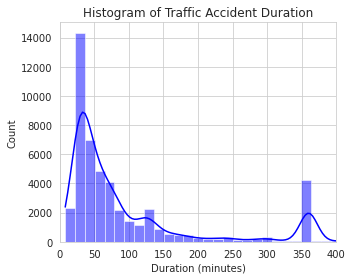

In [9]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Sample data

# Define the quantiles
quantiles = np.quantile(DX, [0.2, 0.4, 0.6, 0.8, 1.0])

# Set the style
sns.set_style('whitegrid')

# Create the histogram
plt.figure(figsize=(5, 4))
sns.histplot(DX, bins=50, kde=True, color='blue')

# Add quantile ticks and labels
# for q in quantiles:
#     plt.axvline(x=q, color='red', linestyle='--', alpha=0.8)
#     plt.text(q, 0, f'{q:.0f}', rotation=45, color='red', verticalalignment='bottom')

# Set title and labels
plt.title('Histogram of Traffic Accident Duration')
plt.xlabel('Duration (minutes)')
plt.ylabel('Count')
plt.xlim(0,400)
# Save as PDF
plt.tight_layout()
plt.savefig('traffic_accident_histogram.pdf', format='pdf')

# Show the plot
plt.show()


In [12]:


# Usage:



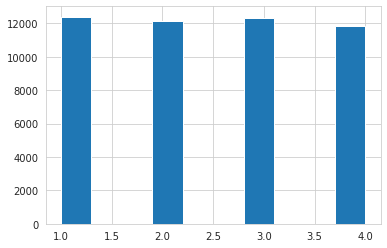

In [15]:
import matplotlib.pyplot as plt
plt.hist(SX,bins=10)
print()

In [16]:
len(SX)

48714

In [21]:
TX.shape

(48714, 43)

In [26]:
DX

array([360.,  34.,  22.,  30.,  60.,  30.])

In [28]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from math import sqrt
import pandas as pd
from sklearn.base import clone
from sklearn.linear_model import SGDRegressor

from sklearn.linear_model import ElasticNet
model = ElasticNet()
# Define the models
models = {
    "Linear Regression": LinearRegression(),
#     "SGD": SGDRegressor(loss='huber',max_iter=1000),
    "ElasticNet": ElasticNet(),
    "DecisionTree": DecisionTreeRegressor(max_depth=8),
#     "LightGBM": LGBMRegressor(),
#     "Random Forest": RandomForestRegressor(),
#     "Gradient Boosting": GradientBoostingRegressor(),
    "XGBoost": XGBRegressor(n_estimators=50,n_jobs=1) 
}

FX = load_features('roberta') #'bert','gpt2'
VX = perform_pca(FX,32)

# Prepare data (X, y)
XES = np.concatenate([VX,TX],axis=1) #VX only, TX only, VX+TX
YES = np.log1p(DX)  # Apply log1p transformation to the target

# Function to compute the Mean Absolute Percentage Error (MAPE)
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.expm1(y_true), np.expm1(y_pred)  # Apply expm1 before calculating the metrics
    return np.mean(np.where(y_true != 0, np.abs((y_true - y_pred) / y_true), 0)) * 100

# For storing results
results = []

# Define KFold cross-validation
kf = KFold(n_splits=5)

# Function to perform cross-validation
def cross_validate(model, X, y, kf):
    rmse_scores = []
    mape_scores = []

    for train_index, test_index in kf.split(X):
        # Create a clone of the model to ensure that the model's initial state is preserved
        model_clone = clone(model)

        # Split the data
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Fit the model
        print(f"Fitting {model.__class__.__name__}...")
        model_clone.fit(X_train, y_train)
        
        # Make predictions
        print("Making predictions...")
        y_pred = model_clone.predict(X_test)
        
        y_pred = np.clip(y_pred, 0, np.log1p(720))
        # Calculate RMSE
        mse_score = np.mean((np.expm1(y_test) - np.expm1(y_pred)) ** 2)
        rmse_score = np.sqrt(mse_score)
        rmse_scores.append(rmse_score)
        
        # Calculate MAPE
        mape_score = mean_absolute_percentage_error(y_test, y_pred)
        mape_scores.append(mape_score)
    
    # Calculate average scores
    average_rmse = np.mean(rmse_scores)
    average_mape = np.mean(mape_scores)
    
    return average_rmse, average_mape

# Calculate cross-validation score for each model
for model_name, model in models.items():
    print(f"Cross-validating {model_name}...")
    average_rmse, average_mape = cross_validate(model, XES, YES, kf)
    results.append([model_name, average_rmse, average_mape])
    print(f"{model_name} cross-validation complete. Average RMSE: {average_rmse}, Average MAPE: {average_mape}\n")

# Convert results to DataFrame for a nice table display
results_df = pd.DataFrame(results, columns=['Model', 'Average RMSE', 'Average MAPE']).round(2)
print(results_df)


Starting PCA...
PCA complete.
Reduced data shape: (48714, 32)
Cross-validating Linear Regression...


IndexError: index 9743 is out of bounds for axis 0 with size 6

In [101]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, ElasticNet
from math import sqrt
import pandas as pd
from sklearn.base import clone

# Define the models
models = {
    "Linear Regression": LinearRegression(),
    "ElasticNet": ElasticNet(),
    "DecisionTree": DecisionTreeRegressor(),
    "XGBoost": XGBRegressor(n_estimators=50, n_jobs=1) 
}

# List of language models
language_models = ['roberta', 'bert', 'gpt2', 'mt5','xlnet']

# language_models = ['xlnet']

# Feature sets
feature_sets = ['VX', 'TX', 'VX+TX']

feature_sets = ['VX', 'VX+TX']

# Function to compute the Mean Absolute Percentage Error (MAPE)
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.expm1(y_true), np.expm1(y_pred)  # Apply expm1 before calculating the metrics
    return np.mean(np.where(y_true != 0, np.abs((y_true - y_pred) / y_true), 0)) * 100

# Define KFold cross-validation
kf = KFold(n_splits=5)

# Function to perform cross-validation
def cross_validate(model, X, y, kf):
    rmse_scores = []
    mape_scores = []
    for train_index, test_index in kf.split(X):
        # Create a clone of the model to ensure that the model's initial state is preserved
        model_clone = clone(model)
        # Split the data
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        # Fit the model
        model_clone.fit(X_train, y_train)
        # Make predictions
        y_pred = model_clone.predict(X_test)
        # Calculate RMSE
        mse_score = np.mean((np.expm1(y_test) - np.expm1(y_pred)) ** 2)
        rmse_score = np.sqrt(mse_score)
        rmse_scores.append(rmse_score)
        # Calculate MAPE
        mape_score = mean_absolute_percentage_error(y_test, y_pred)
        mape_scores.append(mape_score)
    # Calculate average scores
    average_rmse = np.mean(rmse_scores)
    average_mape = np.mean(mape_scores)
    return average_rmse, average_mape


results = []
y = np.log1p(DX)
# Calculate cross-validation score for each model
for language_model in language_models:
    print(f"Loading features for language model: {language_model}...")
    FX = load_features(language_model)[filtered]
    VX = perform_pca(FX, 32)
    for feature_set in feature_sets:
        if feature_set == 'VX':
            X = VX
        elif feature_set == 'TX':
            X = TX
        elif feature_set == 'VX+TX':
            X = np.concatenate([VX,TX],axis=1)
        for model_name, model in models.items():
            print(f"Cross-validating {model_name} with {feature_set} features from {language_model}...")
            average_rmse, average_mape = cross_validate(model, XES, YES, kf)
            results.append([language_model, feature_set, model_name, average_rmse, average_mape])
            print(f"{model_name} cross-validation complete. Average RMSE: {average_rmse}, Average MAPE: {average_mape}\n")

# Convert results to DataFrame for a nice table display
results_df = pd.DataFrame(results, columns=['Language Model', 'Features', 'Model', 'Average RMSE', 'Average MAPE']).round(2)
print(results_df)


Loading features for language model: roberta...
Starting PCA...
PCA complete.
Reduced data shape: (47915, 32)
Cross-validating Linear Regression with VX features from roberta...
Linear Regression cross-validation complete. Average RMSE: 104.8884906958792, Average MAPE: 70.70305116168046

Cross-validating ElasticNet with VX features from roberta...
ElasticNet cross-validation complete. Average RMSE: 118.48861009170032, Average MAPE: 79.36174039553539

Cross-validating DecisionTree with VX features from roberta...
DecisionTree cross-validation complete. Average RMSE: 130.30401799298437, Average MAPE: 111.17382413138598

Cross-validating XGBoost with VX features from roberta...
XGBoost cross-validation complete. Average RMSE: 98.44843735025587, Average MAPE: 68.22698880664606

Cross-validating Linear Regression with VX+TX features from roberta...
Linear Regression cross-validation complete. Average RMSE: 101.31657877888654, Average MAPE: 65.5828456851471

Cross-validating ElasticNet with 

/home/agrigore/ENV/lib64/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: overflow encountered in expm1
/home/agrigore/ENV/lib64/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: overflow encountered in expm1


ElasticNet cross-validation complete. Average RMSE: 118.48861009170032, Average MAPE: 79.36174039553539

Cross-validating DecisionTree with VX features from gpt2...
DecisionTree cross-validation complete. Average RMSE: 118.49278711700863, Average MAPE: 79.37938348365506

Cross-validating XGBoost with VX features from gpt2...
XGBoost cross-validation complete. Average RMSE: 118.50034867412435, Average MAPE: 79.37377169022444

Cross-validating Linear Regression with VX+TX features from gpt2...
Linear Regression cross-validation complete. Average RMSE: 2.132279110661904e+63, Average MAPE: 3.889603042325823e+60

Cross-validating ElasticNet with VX+TX features from gpt2...
ElasticNet cross-validation complete. Average RMSE: 105.53332099580284, Average MAPE: 69.01677358761617

Cross-validating DecisionTree with VX+TX features from gpt2...
DecisionTree cross-validation complete. Average RMSE: 90.26999057830906, Average MAPE: 65.24157379629993

Cross-validating XGBoost with VX+TX features from

In [102]:
results_df[results_df.Features=='TX']['Language Model']='-'

In [103]:
def replace_feature_values(df):
    df = df.copy()  # Make a copy of the DataFrame to avoid modifying the original
    df['Features'] = df['Features'].replace({'VX': 'LLM-features', 'TX': 'Report-features', 'VX+TX': 'LLM-features + Report-features'})
    
    # Replace 'Language Model' with '-' when 'Features' is 'Report-features'
    df.loc[df['Features'] == 'Report-features', 'Language Model'] = '-'
    
    return df
results_df = replace_feature_values(results_df.round(1))

In [104]:
results_df

,Language Model,Features,Model,Average RMSE,Average MAPE
0,roberta,LLM-features,Linear Regression,1.049000e+02,7.070000e+01
1,roberta,LLM-features,ElasticNet,1.185000e+02,7.940000e+01
2,roberta,LLM-features,DecisionTree,1.303000e+02,1.112000e+02
3,roberta,LLM-features,XGBoost,9.840000e+01,6.820000e+01
4,roberta,LLM-features + Report-features,Linear Regression,1.013000e+02,6.560000e+01
5,roberta,LLM-features + Report-features,ElasticNet,1.055000e+02,6.900000e+01
6,roberta,LLM-features + Report-features,DecisionTree,9.280000e+01,6.400000e+01
7,roberta,LLM-features + Report-features,XGBoost,7.110000e+01,4.260000e+01
8,bert,LLM-features,Linear Regression,1.044000e+02,6.880000e+01
9,bert,LLM-features,ElasticNet,1.185000e+02,7.940000e+01


In [105]:
def calculate_average(df):
    df = df.copy()  # Make a copy of the DataFrame to avoid modifying the original
    # Group by 'Features' and 'Model', then calculate mean for 'Average RMSE' and 'Average MAPE'
    df_avg = df.groupby(['Language Model','Features', 'Model'], as_index=False).mean()
    
    return df_avg
results_df = calculate_average(results_df)

In [106]:
def calculate_average(df):
    df = df.copy()  # Make a copy of the DataFrame to avoid modifying the original
    # Group by 'Features' and 'Model', then calculate mean for 'Average RMSE' and 'Average MAPE'
    df_avg = df.groupby(['Language Model','Features', 'Model'], as_index=False).mean()
    
    return df_avg
results_df = calculate_average(results_df)
results_df.to_csv('results-LLM-32.csv')

In [90]:
# !pip install hpelm

In [30]:
!pip install xgboost

     |████████████████████████████████| 173.6 MB 17.9 MB/s                                        | 1.3 MB 5.0 MB/s eta 0:00:355.0 MB/s eta 0:00:34              | 10.6 MB 5.0 MB/s eta 0:00:33                        | 25.0 MB 5.0 MB/s eta 0:00:303 MB 5.0 MB/s eta 0:00:29�▊                         | 36.6 MB 5.0 MB/s eta 0:00:28          | 40.8 MB 5.0 MB/s eta 0:00:27:16                 | 51.6 MB 7.8 MB/s eta 0:00:16                 | 53.9 MB 7.8 MB/s eta 0:00:161615                | 60.5 MB 7.8 MB/s eta 0:00:15  |███████████▊                    | 63.6 MB 7.8 MB/s eta 0:00:15███                  | 75.9 MB 20.1 MB/s eta 0:00:05�██████████▉               | 91.3 MB 20.1 MB/s eta 0:00:05█████████████              | 97.3 MB 20.1 MB/s eta 0:00:04��█▎             | 98.9 MB 20.1 MB/s eta 0:00:04  |███████████████████▍            | 105.5 MB 20.1 MB/s eta 0:00:04    |███████████████████▊            | 107.1 MB 64.2 MB/s eta 0:00:02��██████████████████▌           | 111.2 MB 64.2 MB/s eta 0:00:01B 64.